In [1]:
# Import all necessary libraries
import re
import time
import jinja2
import datetime
import matplotlib
import pandas as pd
import matplotlib.cm as cm
from string import Template
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium import webdriver
from bokeh.palettes import Plasma
from bokeh.embed import components
from bokeh.resources import INLINE
from bokeh.util.browser import view
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, OpenURL, TapTool, PanTool, ResetTool, SaveTool, WheelZoomTool, LinearColorMapper, ColorBar, Range1d

# Path to store the files
path = 'build/'

# Name of the csv-file with the scraped data
output_csv = 'StartNext_Projects.csv'

# Name of the pdf-plot
output_pdf = 'StartNext_Projects.pdf'

# Name of the created interactive plot
output_html = 'Startnext_Projects.html'

In [2]:
def getHTML():
    '''
    Loads the page and scrolls down,
    until no content is loaded anymore
    
    Returns a BeautifulSoup-element with the html-code
    '''
    # Url to scrape the data
    url = 'https://www.startnext.com/Projekte.html'

    # Create a selenium driver
    driver = webdriver.Firefox()
    driver.get(url)


    letters = 0
    # Check if the page has loaded additional content
    while letters < len(driver.page_source):
        letters = len(driver.page_source)
        # Scroll down to the end of the page
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        # Wait for the javascript to load
        time.sleep(5)

    # Get the html-code
    html = driver.page_source
    bs = BeautifulSoup(html, 'lxml')

    # Close the driver
    driver.close()
    
    return bs

In [3]:
def scrapeData():
    '''
    Scrapes every project's data
    and stores the data in a csv-file
    
    Returns a DataFrame, which contains the data
    '''
    projects = []
    # Iterates over each project
    for article in bs.findAll('article', {'class':'article-card'}):
        # Scrape the data
        category = article.find('div', {'class':'category'}).get_text().strip()
        headline = article.find('header', {'class':'headline'}).get_text().strip()
        teaser = article.find('div', {'class':'teaser'}).get_text().strip()
        facts = article.find('div', {'class':'facts-row'})
        money = facts.find('span', {'class':'value'}).get_text().strip()
        finance = money.split('\n', 1)[0].replace('.', '')
        procent = money.split('(', 1)[1][:-2]
        days_left = facts.get_text().strip().rsplit('\n', 1)[-1].split(' ')[1]
        link = article.find('a')['href']

        # Store each project in a row
        projects.append([category, headline, teaser, int(finance), int(procent), int(days_left), link])

    # Create the DataFrame
    df = pd.DataFrame(projects, columns=['Category', 'Headline', 'Teaser', 'Money', 'Percentage', 'Days_left', 'Link'])

    # Get min/max for the color mapping
    minima = df['Percentage'].min()
    maxima = df['Percentage'].max()

    # Create a color-mapper
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.copper)

    def rgba_to_hex(color):
        '''
        Needs a rgba-color tuple
        
        Returns the converted hex-code color
        '''
        return '#%02x%02x%02x' % (int(color[0]*255), int(color[1]*255), int(color[2]*255))

    # Apply the color-mapper to the DataFrame
    df['Color'] = df['Percentage'].apply(mapper.to_rgba).apply(rgba_to_hex)

    # Save the DataFrame to a csv-file
    df.to_csv(path+output_csv, index=False)
    
    return df

In [4]:
def plotPlot(cmap='copper'):
    '''
    Loads the stored DataFrame
    and plots it 
    '''
    # Load the DataFrame
    df = pd.read_csv(path+output_csv)
    
    # Set the labels
    title = 'Current projects at Startnext.com'
    xlabel = 'Days left for funding'
    ylabel = 'Funds collected in €'
    barlabel = 'Percentage of reached funding'

    # Plot plot
    plt.figure(figsize=(13, 8))
    plt.style.use('ggplot')
    plt.scatter(x=df['Days_left'], y=df['Money'], s=df['Percentage'], c=df['Percentage'], cmap=cmap)
    cbar = plt.colorbar()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar.ax.set_ylabel(barlabel)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.savefig(path+output_pdf)
    plt.show()

In [5]:
def plotInteractivePlot():
    '''
    Loads the stored DataFrame
    and created an interactive bokeh plot 
    '''
    # Load DataFrame
    df = pd.read_csv(path+output_csv)
    df = df.sort_values(by='Percentage', ascending=True)

    # Get min/max for color-mapper
    minima = df['Percentage'].min()
    maxima = df['Percentage'].max()

    # Set the labels
    title = 'Erfolge der aktuellen Startnext-Projekte - {}'.format(datetime.date.today())
    xlabel = 'Verbleibende Tage für die Finanzierung'
    ylabel = 'Gesammeltes Geld [€]'
    colorbarlabel = 'Farbe und Größe: Prozentsatz des erreichten Finanzierungszieles'

    # Create the internal data-structure
    source = ColumnDataSource(data=dict(
        x=df['Days_left'],
        y=df['Money'],
        p=df['Percentage'],
        # Ensure visibility and proportions
        s=df['Percentage'].pow(1/2)*2+3, 
        color=df['Color'],
        headline=df['Headline'],
        category=df['Category'],
        link=df['Link']
    ))

    # Load useful tools
    pan = PanTool()
    reset = ResetTool()
    save = SaveTool()
    zoom = WheelZoomTool()
    tap = TapTool()

    # Create the hovertool with its data
    hover = HoverTool(tooltips=[
        ("Titel", "@headline"),
        ("Kategorie", "@category"),
        ("Verbleibende Tage", "@x"),
        ("Geld", "@y"),
        ("Prozentsatz", "@p"),
    ])
    
    # Create a color-mapper
    pal = Plasma[256]
    color = LinearColorMapper(high=maxima, low=minima, palette=pal)

    # Create the figure and plot the circles
    p = figure(plot_width=900, plot_height=600, tools=[hover, pan, reset, save, zoom, tap], active_scroll=zoom, title=title, toolbar_location="above")
    p.circle('x', 'y', size='s', source=source, color={'field': 'p', 'transform': color})

    # Add a colorbar
    color_bar = ColorBar(orientation='horizontal', color_mapper=color, label_standoff=12, border_line_color=None, location=(0,0), title=colorbarlabel)
    p.add_layout(color_bar, 'below')

    # Add an interactive taptool
    taptool = p.select(type=TapTool)
    taptool.callback = OpenURL(url='@link')

    # Refine the layout
    p.x_range = Range1d(90, 0)
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel

    # Split the figure's data
    script, div = components(p)

    # Create a the wrapping html-code
    template = jinja2.Template(Template('''<!DOCTYPE html>
    <html lang="de">
        <head>
            <meta charset="utf-8">
            <title>Startnext Projekte</title>
            {{ js_resources }}
            {{ css_resources }}
            {{ script }}
        <style>
              html {
                width: 100%;
                height: 100%;
              }
              body {
                font-family: sans-serif;
                width: 90%;
                height: 100%;
                margin: auto;
              }
            </style>
        </head>
        <body>
        <center>

            <div class="Bedienung">
              <center><h1>Aktuelle Projekte auf <a href="https://www.startnext.com/">Startnext</a> - $val</h1></center>
              <center><p style="width:600pt;text-align:left;">
                Die Grafik zeigt die derzeitig finanzierbaren Projekte auf <a href="https://www.startnext.com/">Startnext</a>.
                Dabei sind die noch laufenden Tage gegen das schon gesammelte Geld aufgetragen.
                Zusätzlich kennzeichnet die Farbe und Größe noch den Status des zu erreichenden Zieles.
              </p></center>
              <center><p style="width:600pt;text-align:left">
                Folgende Werkzeuge stehen Ihnen oben rechts beim Untersuchen der Grafik zur Verfügung:
                <ul style="width:550pt;text-align:left">
                    <li><b>Pan</b> - zum Verschieben mit gedrückter linker Maustaste</li>
                    <li><b>Wheel Zoom</b> - zum Zoomen mit dem Mausrad</li>
                    <li><b>Tap</b> - zum Auswählen durch klicken (Sie werden dann auf die Projektseite weitergeleitet)</li>
                    <li><b>Reset</b> - zum Wechseln in die ursprüngliche Ansicht</li>
                    <li><b>Save</b> - zum Abspeichern der aktuellen Ansicht</li>
                    <li><b>Hover</b> - zum Einblenden von Zusatzinformationen beim Überfahren der Projekte mit der Maus</li>
                </ul>
              </p></center>
            </div>
        <center>
        {{ div }}
        </center>
        </body>
    </html>''').substitute(val=datetime.date.today()))

    # Combine the html-code with the plot
    js_resources = INLINE.render_js()
    css_resources = INLINE.render_css()
    html = template.render(js_resources=js_resources, css_resources=css_resources, script=script, div=div)

    # Write everything into a html-file
    with open(path+output_html, 'w') as f:
        f.write(html)

    # Examine the plot
    view(path+output_html)

In [6]:
def loadMailAdresses():
    '''
    Loads each project's webpage and scrapes the mail-adresses to send the plot
    Executes the needed javascripts
    Extends the DataFrame by the adresses
    
    Returns an extended DataFrame
    '''
    # Compile the pattern for mail-adresses
    pattern = re.compile('\S+@\S+\.\S+')
    
    # Create a selenium driver
    driver = webdriver.Firefox()

    mail_adresses = []
    # Iterate over every project
    df = pd.read_csv(path+output_csv)
    for url in df['Link'].values:
        # Load the project's webpage
        driver.get(url)

        try:
            # Try to activate the impressum
            element = driver.find_element_by_xpath("//a[@class='btn-imprint-toggle pull-left js-imprint-toggler']")
            element.click()
            # Wait for the impressum to load
            time.sleep(1)
        except:
            pass

        # Get the html-code
        html = driver.page_source
        bs = BeautifulSoup(html, 'lxml')

        # Scrape all mail-adresses; if they are to long it could be javacript
        adresses = [adress for adress in re.findall(pattern, bs.get_text()) if len(adress) < 50]
        mail_adresses.append([url, adresses])

    # Close driver
    driver.close()

    # Extend the DataFrame
    url, adresses = zip(*mail_adresses)
    df['Adresses'] = adresses
    
    # Save the DataFrame
    df.to_csv(path+output_csv, index=False)
    
    return df

In [7]:
bs = getHTML()

In [8]:
df = scrapeData()

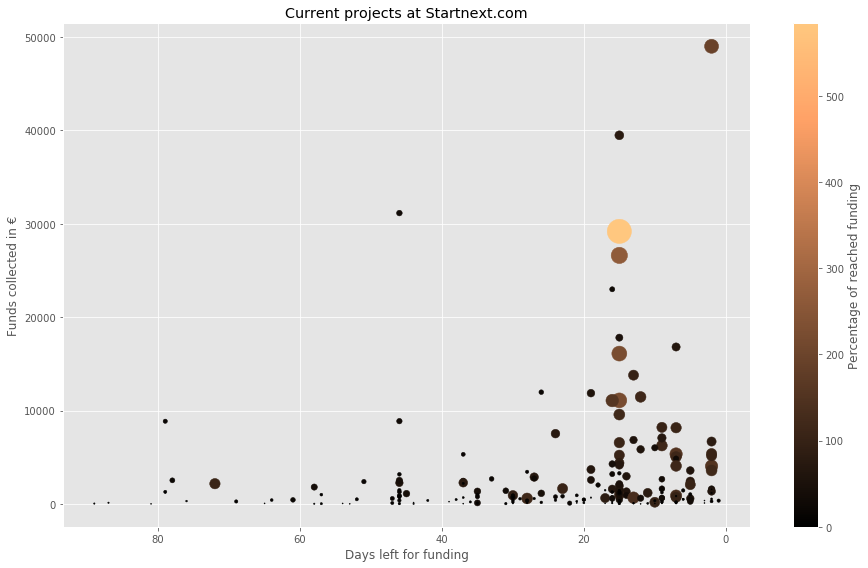

In [9]:
plotPlot()

In [10]:
plotInteractivePlot()

/home/jm/anaconda3/lib/python3.6/site-packages/bokeh/core/json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


In [11]:
df = loadMailAdresses()